<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функций

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report

In [ ]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='PuBu', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted", zero_division=0)
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  return

def plot_roc_curve(y_test, y_prob, figsize=(5,5)):

  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([-0.01, 1.0])
  ax.set_ylim([0.0, 1.01])
  ax.set_xlabel('False Positive Rate', fontsize=12)
  ax.set_ylabel('True Positive Rate', fontsize=12)
  ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
  ax.plot(fpr, tpr, label='AUC = %0.3f' % (roc_auc))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  plt.show()

# Чтение данных

In [ ]:
df = pd.read_excel("https://docs.google.com/spreadsheets/d/e/2PACX-1vQFF3mjUeHP3CWhZqdeVInESL3eFN72K1urhfuBWoiG9bXwZqRt-7Cjaf2Ls5fltDXd_D7nk75SLcPC/pub?output=xlsx")
df.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [ ]:
df.shape

(25000, 2)

In [ ]:
df = df.iloc[0:5000]

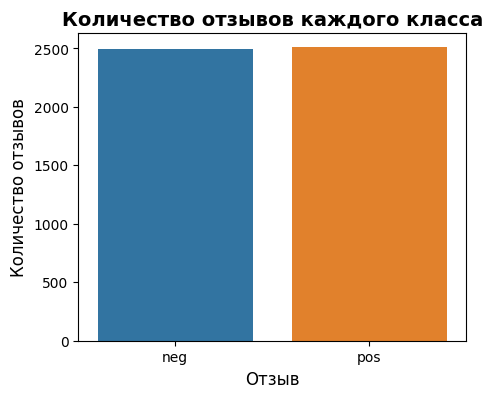

In [ ]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='sentiment')

plt.xlabel('Отзыв', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.title('Количество отзывов каждого класса', fontsize=14, fontweight="bold");

# Предобработка данных




Удалим из текста перенос строки, пунктуацию, и приведем все буквы к нижнему регистру

In [ ]:
def unify_fragment(elem):
  elem = re.sub(r'[^\w\s]', ' ', elem)
  elem = re.sub(r'\n', ' ', elem)
  elem = elem.lower()
  elem = ' '.join(elem.split())

  return elem

In [ ]:
df["text"] = df["text"].apply(unify_fragment)

In [ ]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["sentiment"])

In [ ]:
df

,text,sentiment,label
0,my daughter liked it but i was aghast that a c...,neg,0
1,i no words no words can describe this i will t...,neg,0
2,this film is basically a poor take on the old ...,neg,0
3,this is a terrible movie and i m not even sure...,neg,0
4,first of all this movie is a piece of reality ...,pos,1
...,...,...,...
4995,this documentary sheds absolutely no light on ...,neg,0
4996,although the plot of this film is a bit far fe...,pos,1
4997,the detective story is not typical for the mat...,pos,1
4998,i am a huge fan of harald zwart and i just kne...,pos,1


# Получим токенизатор

In [ ]:
def get_max_word_count(data):
  max = 0
  for elem in data:
    if (len(elem.split()) > max):
      max = len(elem.split())

  return max

In [ ]:
max_length = get_max_word_count(df["text"])
max_length

1117

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentences = df["text"]

In [ ]:
input_ids = []
attention_masks = []
max_length = get_max_word_count(df["text"])

if (max_length > 512):
  max_length = 124

for sent in sentences:
  bert_inp = tokenizer.encode_plus(sent,
                                   add_special_tokens=True,
                                   max_length=124,
                                   pad_to_max_length=True,
                                   truncation=True,
                                   return_attention_mask=True)

  input_ids.append(bert_inp['input_ids'])
  attention_masks.append(bert_inp['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
target = np.array(pd.get_dummies(df['label']))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Деление на выборки

In [ ]:
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(input_ids, target, attention_masks, test_size=0.1, random_state = 47)
X_train, X_val, y_train, y_val, train_mask, val_mask = train_test_split(X_train, y_train, train_mask, test_size=0.1, random_state = 47)

In [ ]:
y_tested = np.argmax(y_test, axis=1)

In [ ]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (4050, 124)
Размер валидационной выборки: (450, 124)
Размер тестовой выборки: (500, 124)


# Создание модели

## Bert transfer learning

In [ ]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(32, activation='relu')(output)
    output = keras.layers.Dropout(0.25)(output)
    output = keras.layers.Dense(8, activation='relu')(output)
    output = keras.layers.Dense(df['sentiment'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)


    for layer in model.layers[:5]:
        layer.trainable = False
    return model

In [ ]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                             

In [ ]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
64/64 [==============================] - 63s 723ms/step - loss: 0.6482 - accuracy: 0.6202 - val_loss: 0.6006 - val_accuracy: 0.6800
Epoch 2/6
64/64 [==============================] - 43s 671ms/step - loss: 0.5703 - accuracy: 0.7096 - val_loss: 0.5864 - val_accuracy: 0.6778
Epoch 3/6
64/64 [==============================] - 43s 678ms/step - loss: 0.5301 - accuracy: 0.7353 - val_loss: 0.5061 - val_accuracy: 0.7600
Epoch 4/6
64/64 [==============================] - 43s 667ms/step - loss: 0.5071 - accuracy: 0.7640 - val_loss: 0.4770 - val_accuracy: 0.7667
Epoch 5/6
64/64 [==============================] - 44s 682ms/step - loss: 0.5063 - accuracy: 0.7551 - val_loss: 0.4654 - val_accuracy: 0.7711
Epoch 6/6
64/64 [==============================] - 44s 684ms/step - loss: 0.4887 - accuracy: 0.7696 - val_loss: 0.4521 - val_accuracy: 0.7800


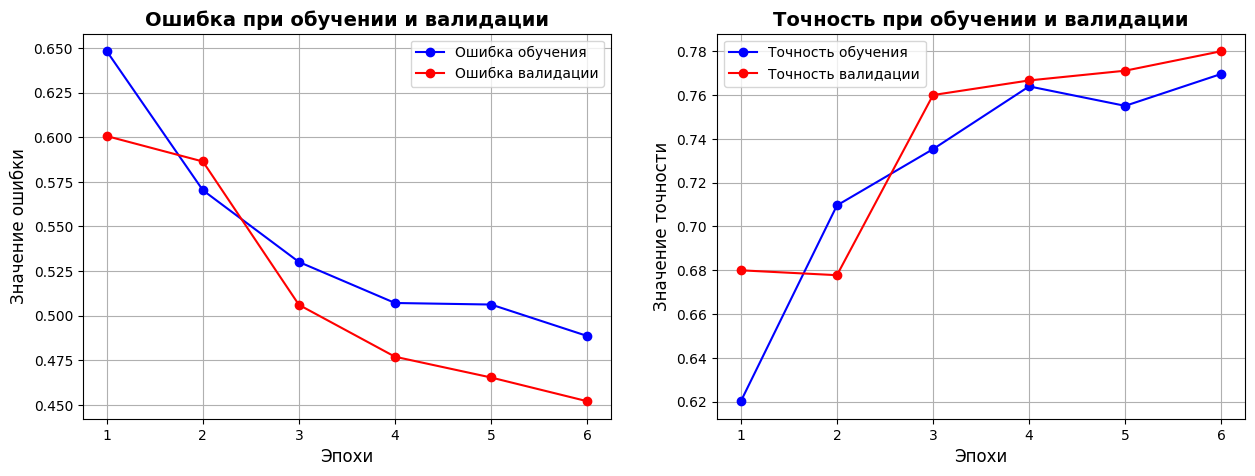

In [ ]:
plot_training_curves(history)

In [ ]:
y_predicted_prob = model.predict([X_test, test_mask])
y_predicted = np.argmax(y_predicted_prob, axis=1)

16/16 [==============================] - 8s 275ms/step


In [ ]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [ ]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.7794
Precision_score:	0.7805
Recall_score:		0.7780
F1_score:		0.7781
AUC Score:		0.8549


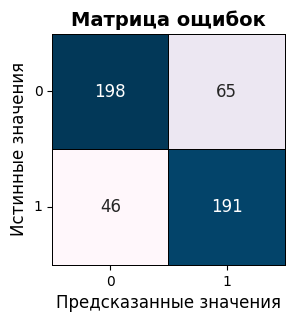

In [ ]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

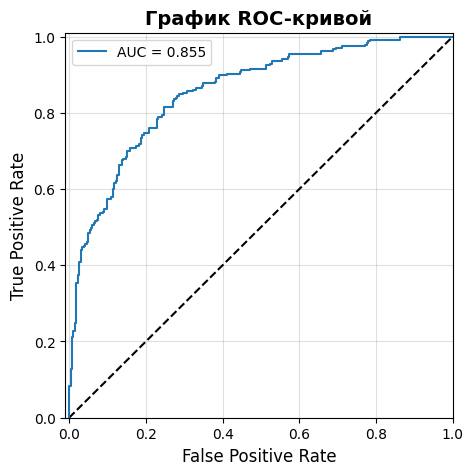

In [ ]:
plot_roc_curve(y_tested, y_prob)

## Bert fine tuning

In [ ]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(16, activation='relu')(output)
    output = keras.layers.Dropout(0.25)(output)
    output = keras.layers.Dense(8, activation='relu')(output)
    output = keras.layers.Dense(df['sentiment'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)

    return model

In [ ]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                           

In [ ]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
127/127 [==============================] - 62s 383ms/step - loss: 0.6873 - accuracy: 0.5457 - val_loss: 0.6628 - val_accuracy: 0.6244
Epoch 2/6
127/127 [==============================] - 44s 350ms/step - loss: 0.6482 - accuracy: 0.6373 - val_loss: 0.6139 - val_accuracy: 0.7200
Epoch 3/6
127/127 [==============================] - 45s 357ms/step - loss: 0.6108 - accuracy: 0.6835 - val_loss: 0.6480 - val_accuracy: 0.6422
Epoch 4/6
127/127 [==============================] - 44s 347ms/step - loss: 0.5854 - accuracy: 0.7012 - val_loss: 0.5410 - val_accuracy: 0.7667
Epoch 5/6
127/127 [==============================] - 44s 347ms/step - loss: 0.5868 - accuracy: 0.6975 - val_loss: 0.5785 - val_accuracy: 0.7044
Epoch 6/6
127/127 [==============================] - 43s 341ms/step - loss: 0.5806 - accuracy: 0.7005 - val_loss: 0.5095 - val_accuracy: 0.7622


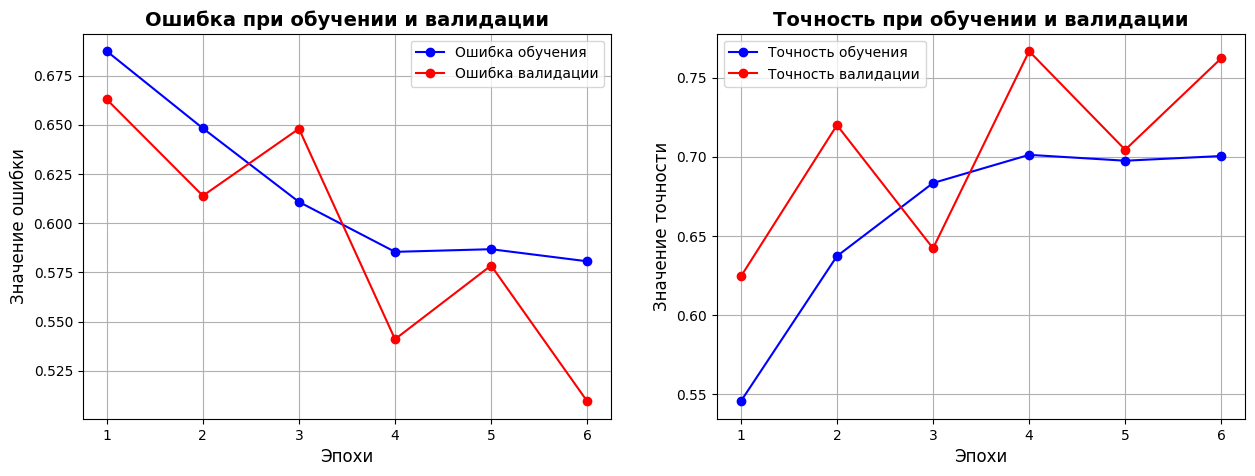

In [ ]:
plot_training_curves(history)

In [ ]:
y_predicted_prob = model.predict([X_test, test_mask]) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1)

16/16 [==============================] - 7s 275ms/step


In [ ]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [ ]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.7517
Precision_score:	0.7523
Recall_score:		0.7520
F1_score:		0.7521
AUC Score:		0.8198


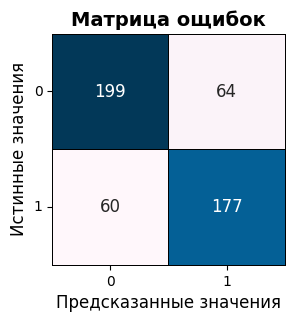

In [ ]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

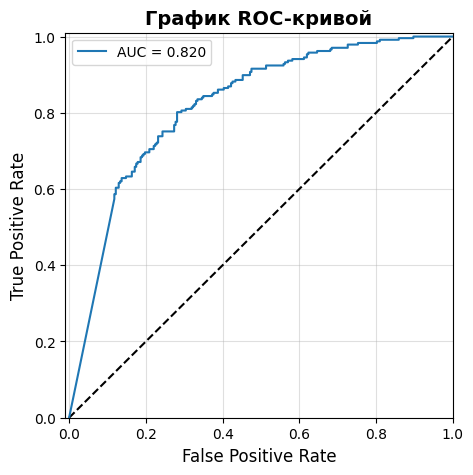

In [ ]:
plot_roc_curve(y_tested, y_prob)

# Чтение данных

In [ ]:
df = pd.read_excel("https://docs.google.com/spreadsheets/d/e/2PACX-1vQFF3mjUeHP3CWhZqdeVInESL3eFN72K1urhfuBWoiG9bXwZqRt-7Cjaf2Ls5fltDXd_D7nk75SLcPC/pub?output=xlsx")
df.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [ ]:
df["text"] = df["text"].apply(unify_fragment)

In [ ]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["sentiment"])

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Создаем токенизатор и обучаем его на всех текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["text"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.1, random_state = 47)

In [ ]:
from keras.utils import to_categorical

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_tested = np.argmax(y_test, axis=1)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Преобразуем тексты в последовательности целых чисел
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Определяем максимальную длину последовательности
max_length = max([len(x) for x in train_sequences])

# Дополняем последовательности до максимальной длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # Размер словаря

## LSTM

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.LSTM(256, return_sequences=True))
model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(df['sentiment'].nunique(), activation='softmax'))

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 2389, 256)         18886400  
                                                                 
 lstm_10 (LSTM)              (None, 2389, 256)         525312    
                                                                 
 lstm_11 (LSTM)              (None, 256)               525312    
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 16)                4112      
                                                                 
 dropout_41 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                

In [ ]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_split=0.1)

Epoch 1/6
633/633 [==============================] - 205s 317ms/step - loss: 0.6938 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.4956
Epoch 2/6
633/633 [==============================] - 184s 290ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4956
Epoch 3/6
633/633 [==============================] - 177s 279ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5044
Epoch 4/6
633/633 [==============================] - 173s 274ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5044
Epoch 5/6
633/633 [==============================] - 172s 271ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6934 - val_accuracy: 0.4956
Epoch 6/6
633/633 [==============================] - 169s 266ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5044


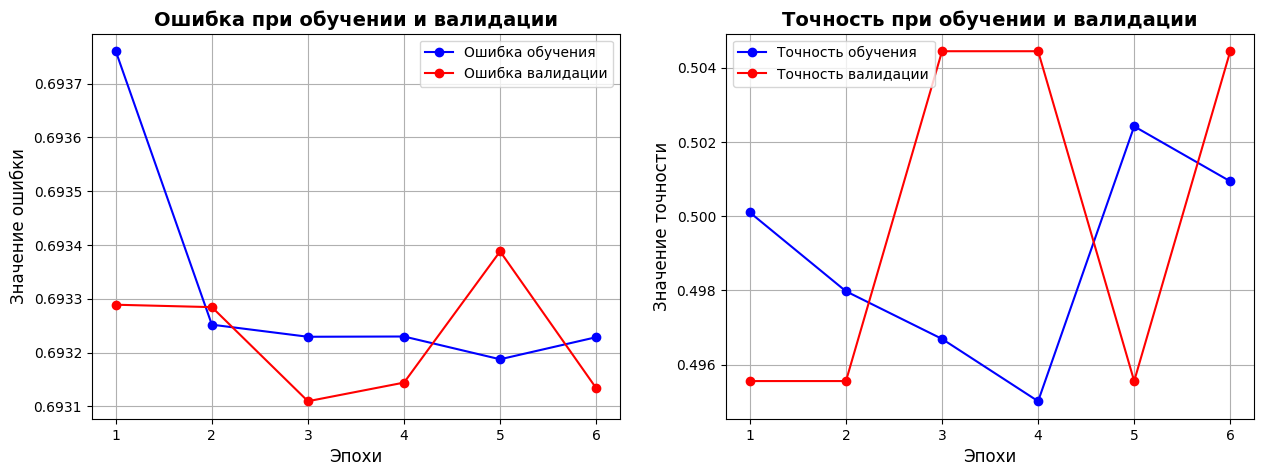

In [ ]:
plot_training_curves(history)

In [ ]:
y_predicted_prob = model.predict(test_padded) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

79/79 [==============================] - 9s 105ms/step


In [ ]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [ ]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.5000
Precision_score:	0.2432
Recall_score:		0.4932
F1_score:		0.3258
AUC Score:		0.5000


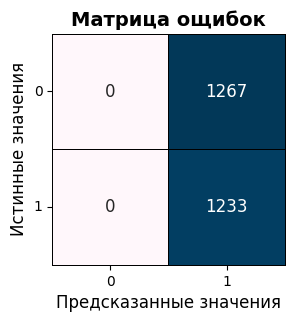

In [ ]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

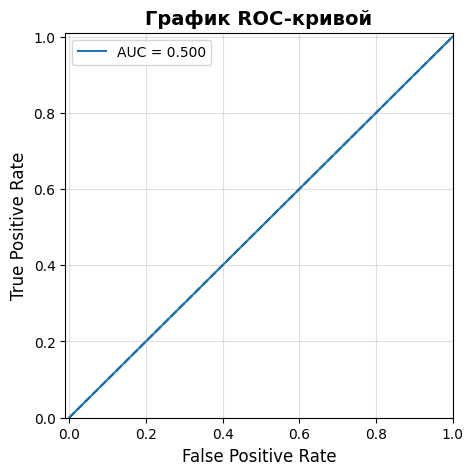

In [ ]:
plot_roc_curve(y_tested, y_prob)

## Bi-LSTM

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(df['sentiment'].nunique(), activation='softmax'))

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 2389, 256)         18886400  
                                                                 
 bidirectional (Bidirection  (None, 2389, 256)         394240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 19691458 (75.12 MB)
Trainable params: 19

In [ ]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_split=0.1)

Epoch 1/6
317/317 [==============================] - 250s 552ms/step - loss: 0.6127 - accuracy: 0.6695 - val_loss: 0.5671 - val_accuracy: 0.7204
Epoch 2/6
317/317 [==============================] - 174s 550ms/step - loss: 0.3304 - accuracy: 0.8665 - val_loss: 0.3354 - val_accuracy: 0.8560
Epoch 3/6
317/317 [==============================] - 171s 538ms/step - loss: 0.2702 - accuracy: 0.8863 - val_loss: 0.5977 - val_accuracy: 0.7227
Epoch 4/6
317/317 [==============================] - 169s 533ms/step - loss: 0.2125 - accuracy: 0.9203 - val_loss: 0.3958 - val_accuracy: 0.8516
Epoch 5/6
317/317 [==============================] - 166s 523ms/step - loss: 0.1467 - accuracy: 0.9480 - val_loss: 0.3180 - val_accuracy: 0.8822
Epoch 6/6
317/317 [==============================] - 165s 519ms/step - loss: 0.0906 - accuracy: 0.9710 - val_loss: 0.3526 - val_accuracy: 0.8849


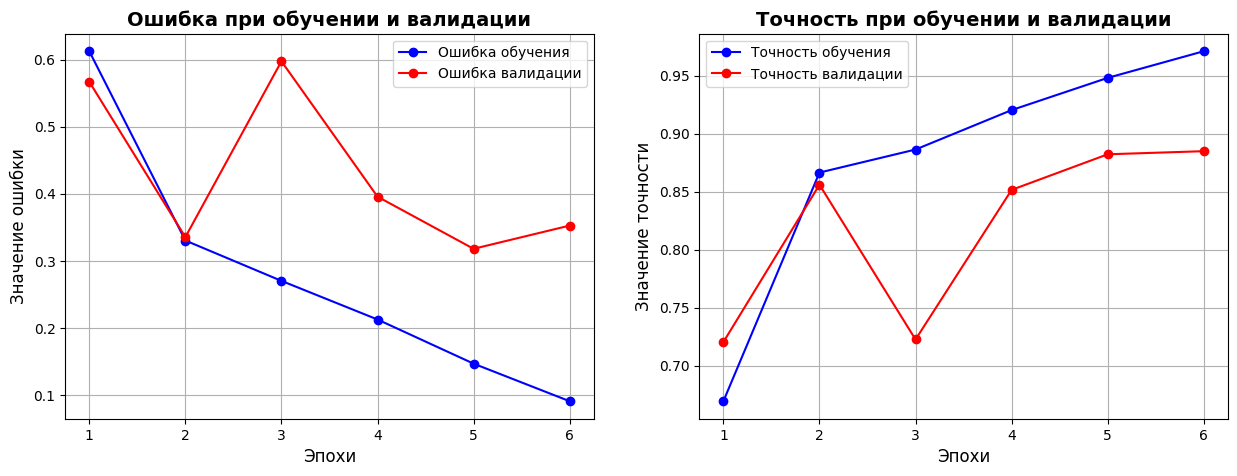

In [ ]:
plot_training_curves(history)

In [ ]:
y_predicted_prob = model.predict(test_padded) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

79/79 [==============================] - 11s 120ms/step


In [ ]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [ ]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.8778
Precision_score:	0.8802
Recall_score:		0.8772
F1_score:		0.8770
AUC Score:		0.9487


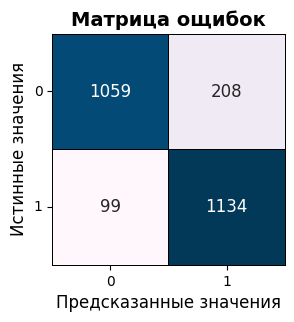

In [ ]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

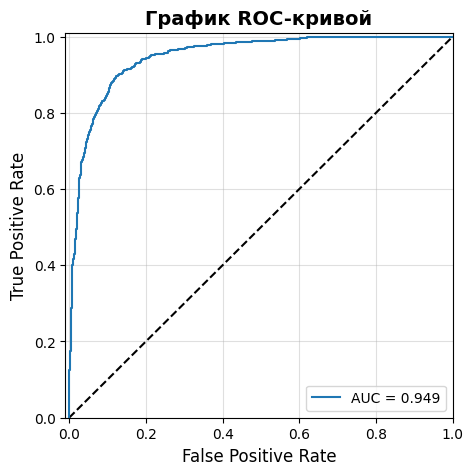

In [ ]:
plot_roc_curve(y_tested, y_prob)